In [1]:
%matplotlib inline

try:
    from model_renderer.pose_renderer import BpyRenderer
except ImportError:
    pass

import os
import numpy as np
import cv2

from generic_pose.utils.image_preprocessing import cropBBox, seg2Mask
from generic_pose.eval.template_pose_estimator import computeT 

from pycocotools.coco import COCO

import matplotlib.pyplot as plt
import pylab
pylab.rcParams['figure.figsize'] = 20, 12

In [2]:
def imshowCV(img):
    #plt.axis('off')
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.show()

In [3]:
annotation_path = '/home/bokorn/data/surgical/images/coco/annotations/instances_train2014.json'
image_path = '/home/bokorn/data/surgical/images/coco/coco_train2014/'
orientation_dir = '/home/bokorn/data/surgical/results/'
results_dir = '/home/bokorn/data/surgical/results'
category_name = 'hemostat'
idx = 7


In [4]:
coco = COCO(annotation_path)
cat_ids = coco.getCatIds(catNms=[category_name])
cats = coco.loadCats(cat_ids)
img_ids = coco.getImgIds(catIds=cat_ids)
ann_ids =  coco.getAnnIds(catIds=cat_ids)

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


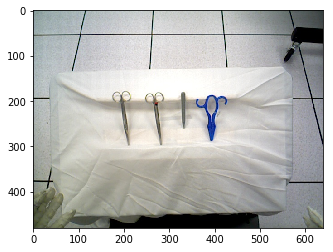

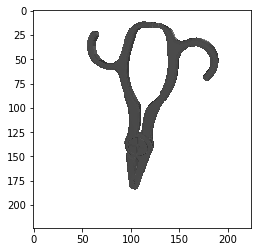

In [18]:
ann_info = coco.loadAnns(ann_ids[idx])[0]
img_info = coco.loadImgs(ann_info['image_id'])[0]
img = cv2.imread(os.path.join(image_path, img_info['file_name']))
render_filename = os.path.join(results_dir, category_name, '000000_rend.png')
template = cv2.imread(render_filename)
imshowCV(img)
imshowCV(template)

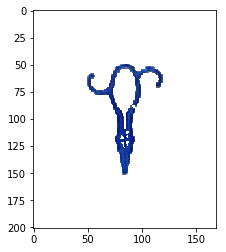

In [6]:
mask = seg2Mask(ann_info['segmentation'], img.shape)
bbox = ann_info['bbox']  
img_crop, corner = cropBBox(np.concatenate([img, mask], axis=2), 
                            bbox, boarder_width = max(bbox[2:])//2)
img_mask = img_crop[:,:,:3] * img_crop[:,:,3:] + 255*(1-img_crop[:,:,3:])
imshowCV(img_mask)

In [7]:
from generic_pose.eval.template_pose_estimator import * 

In [8]:
np.array(img_mask.shape[:2]) / np.array(template.shape[:2])

array([0.89732143, 0.75446429])

In [26]:
bbox_corner = corner
template_dist = 0.2
f_t = 35
f = 570.3422241210938
p = (319.5, 238.5)
diag_t = np.linalg.norm(template.shape[:2])
max_scale = np.min(np.array(img_mask.shape[:2]) / np.array(template.shape[:2]))
scales = np.linspace(0.25, max_scale, 10)
#scales = [1.5, 1.25, 1, .66, .33]
#scales = np.logspace(np.log(0.33)/np.log(10), np.log(1.5)/np.log(10), 50)
image_pyrimid = createMultiscaleImage(template, scales = scales)
max_loc = None
max_lvl = None
max_val = -np.inf
vals = []
scls = []
for pyr_lvl, temp_pyr in enumerate(image_pyrimid):
    if(all(np.array(temp_pyr.shape[:2]) < np.array(img_mask.shape[:2]))):
        loc, val = matchTemplate(temp_pyr, img_mask)
        vals.append(val)
        scls.append(scales[pyr_lvl]) 
        #print(temp_pyr.shape, loc, val)
        if(val > max_val):
            max_val = val
            max_loc = loc
            max_lvl = pyr_lvl

ht, wt = image_pyrimid[max_lvl].shape[:2]
y = max_loc[0] + bbox_corner[0] + ht//2
x = max_loc[1] + bbox_corner[1] + wt//2
diag = np.linalg.norm([ht, wt])

tz = template_dist * diag_t/diag * f/350
ty = tz / f * (y - p[0])
tx = tz / f * (x - p[1])



In [27]:
diag_t, diag, f, f_t

(316.7838379715733, 166.87720036002523, 570.3422241210938, 35)

391 240
0.0016271186440677966 0.0775593220338983 0.6186763109110169


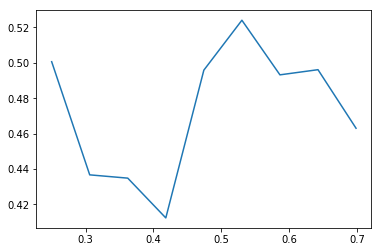

In [28]:
plt.plot(scls, vals)
#print(scales[max_lvl])
print(y,x)
print(tx, ty, tz)
#print(max_loc)

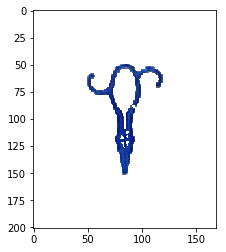

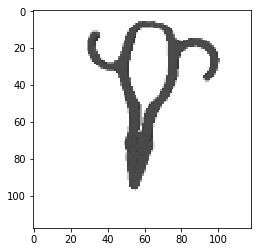

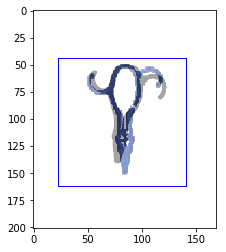

In [11]:
disp_crop = img_mask.copy()
y0, x0 = max_loc
y1, x1 = (max_loc[0] + ht, max_loc[1] + wt)
#print(disp_crop[x0:x1 ,y0:y1].shape)
imshowCV(img_mask)
imshowCV(image_pyrimid[max_lvl])

disp_crop[x0:x1, y0:y1] = 0.5 * disp_crop[x0:x1, y0:y1] + 0.5*image_pyrimid[max_lvl]

cv2.rectangle(disp_crop, (y0,x0), (y1,x1), (255,0,0))
imshowCV(disp_crop)

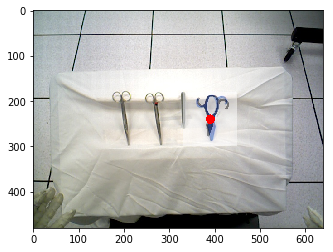

In [12]:
disp_img = img.copy()
y0, x0 = (y - int(np.floor(ht/2)), int(x - np.floor(wt/2)))
y1, x1 = (y + int(np.ceil( ht/2)), int(x + np.ceil( wt/2)))
disp_img[x0:x1, y0:y1] = 0.5 * disp_img[x0:x1, y0:y1] + 0.5*image_pyrimid[max_lvl]

cv2.circle(disp_img, (y,x), 10, (0,0,255), -1)
#cv2.rectangle(disp_img, max_loc, (max_loc[0] + ht, max_loc[1] + wt), (255,0,0))
imshowCV(disp_img)

In [13]:
computeT(img_mask, template, 570.3422241210938, (319.5, 238.5), bbox_corner=corner)

array([0.00015409, 0.00734501, 0.05858976])